In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
from functools import partial
import torch
import torch.nn.functional as F
import time
import numpy as np
# from utilities3 import *
from timeit import default_timer
import matplotlib.pyplot as plt

from torch import nn
import os
import glob
from PIL import Image
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

name = "GINO: 500 Epochs Final"
log = 0

################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat,
                             device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 8  # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(8, self.width)  # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x = F.pad(x, [0, self.padding, 0, self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

# # ################################################################
# configs
################################################################

class StereoKITTIDataset(Dataset):
    def __init__(self, left_dir, right_dir, disp_dir, transform=True):
        self.left_paths  = sorted(glob.glob(os.path.join(left_dir, "*.png")))
        self.right_paths = sorted(glob.glob(os.path.join(right_dir, "*.png")))
        self.disp_paths  = sorted(glob.glob(os.path.join(disp_dir, "*.png")))
        self.transform = transform

        # print(f'left:{len(self.left_paths)}')
        # print(f'right:{len(self.right_paths)}')
        # print(f'disp:{len(self.disp_paths)}')

        assert len(self.left_paths) == len(self.right_paths) == len(self.disp_paths), \
            "Dataset size mismatch!"

    def __len__(self):
        return len(self.left_paths)

    def __getitem__(self, idx):
        left  = np.array(Image.open(self.left_paths[idx]).convert("RGB"), dtype=np.float32) / 255.0
        right = np.array(Image.open(self.right_paths[idx]).convert("RGB"), dtype=np.float32) / 255.0

        # --- FIX FOR KITTI DISPARITY ---
        disp_raw = np.array(Image.open(self.disp_paths[idx]), dtype=np.uint16)
        disp = disp_raw.astype(np.float32) / 256.0

        # print("LEFT:", left.shape)
        # print("RIGHT:", right.shape)
        # print("DISP:", disp.shape)

        # Convert to torch tensors: (C,H,W)
        left  = torch.tensor(left).permute(2,0,1).float()
        right = torch.tensor(right).permute(2,0,1).float()
        disp  = torch.tensor(disp).unsqueeze(0).float()

        # Input to model = concatenation of left/right
        inp = torch.cat([left, right], dim=0)   # (6,H,W)

        return inp, disp

class StereoKITTI_Test(Dataset):
    def __init__(self, left_dir, right_dir):
        self.left_paths  = sorted(glob.glob(os.path.join(left_dir, "*.png")))
        self.right_paths = sorted(glob.glob(os.path.join(right_dir, "*.png")))

        assert len(self.left_paths) == len(self.right_paths), "Test size mismatch!"

    def __len__(self):
        return len(self.left_paths)

    def __getitem__(self, idx):
        left  = np.asarray(Image.open(self.left_paths[idx]).convert("RGB"), dtype=np.float32) / 255.0
        right = np.asarray(Image.open(self.right_paths[idx]).convert("RGB"), dtype=np.float32) / 255.0

        left  = torch.from_numpy(left).permute(2,0,1)
        right = torch.from_numpy(right).permute(2,0,1)

        inp = torch.cat([left, right], dim=0)
        return inp

def train(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0

    for inp, disp_gt in loader:
        inp, disp_gt = inp.to(device), disp_gt.to(device)

        inp = inp.permute(0, 2, 3, 1)  # (B, H, W, C)

        optimizer.zero_grad()
        pred = model(inp)
        pred = pred.permute(0, 3, 1, 2).contiguous()   # (B, 1, H, W)

        # Mask invalid pixels
        mask = disp_gt > 0
        loss = criterion(pred[mask], disp_gt[mask])

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(loader)


# ============================================================
#   4. TEST + VISUALIZATION
# ============================================================

def test(model, loader, device, save_dir="predictions"):
    """
    Run inference on KITTI test dataset (no ground truth).
    Saves predicted disparity maps as PNG images.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    with torch.no_grad():
        for i, inp in enumerate(loader):
            # If loader returns tuple (inp, _), take only inp
            if isinstance(inp, (list, tuple)):
                inp = inp[0]

            inp = inp.to(device)  # (B,6,H,W)
            inp = inp.permute(0, 2, 3, 1)  # (B, H, W, C)

            # gridx = torch.tensor(np.linspace(0, 1, inp.shape[1]), dtype=torch.float)
            # gridx = gridx.reshape(1, inp.shape[1], 1, 1).repeat([1, 1, inp.shape[2], 1])

            # gridy = torch.tensor(np.linspace(0, 1, inp.shape[2]), dtype=torch.float)
            # gridy = gridy.reshape(1, 1, inp.shape[2], 1).repeat([1, inp.shape[1], 1, 1])

            # latent_queries = torch.cat((gridx, gridy), dim=-1).to(device)

            # Forward pass
            pred = model(inp) #, latent_queries, latent_queries, latent_queries)
            pred = pred.permute(0, 3, 1, 2).contiguous()
            pred_np = pred.squeeze().cpu().numpy()  # (H,W) if batch=1

            # Normalize for saving
            pred_norm = pred_np - pred_np.min()
            if pred_norm.max() > 0:
                pred_norm /= pred_norm.max()
            pred_img = (pred_norm * 255).astype(np.uint8)

            # Save prediction
            Image.fromarray(pred_img).save(os.path.join(save_dir, f"pred_{i:04d}.png"))

            # Optional visualization for first image
            # if i == 0:
            #     plt.figure(figsize=(12,4))
            #     plt.subplot(1,2,1)
            #     plt.title("Left Image Input")
            #     plt.imshow(inp[0,:3].cpu().permute(1,2,0))
            #     plt.subplot(1,2,2)
            #     plt.title("Prediction")
            #     plt.imshow(pred_np, cmap="inferno")
            #     plt.show()

    print(f"Predictions saved to {save_dir}")

# ============================================================
#   5. MAIN PIPELINE
# ============================================================

def main():

    # # -------- YOU ALREADY PROVIDED THESE PATHS --------
    # dataset_paths = {
    #     "images_left_dir": "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_2", # '../../Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_2/'
    #     "images_right_dir": "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_3",
    #     "images_disp_dir": "Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0",
    #     "images_testing_left_dir": "Fast-ACVNet-main/data/KITTI/KITTI_2015/testing/image_2",
    #     "images_testing_right_dir": "Fast-ACVNet-main/data/KITTI/KITTI_2015/testing/image_3"
    # }

    # train_dataset = StereoKITTIDataset(
    #     dataset_paths["images_left_dir"],
    #     dataset_paths["images_right_dir"],
    #     dataset_paths["images_disp_dir"]
    # )

    # # You can split or create a test dataset
    # test_dataset = StereoKITTI_Test(
    # dataset_paths["images_testing_left_dir"],
    # dataset_paths["images_testing_right_dir"]
    # )

    # train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
    # test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False, num_workers=2)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # ----------------- MODEL -----------------
    modes = 12
    width = 32

    model = FNO2d(modes*2, modes, width).cuda() # GINO(in_channels = 6, out_channels = 1).cuda()
    checkpoint = torch.load("Fast-ACVNet-main/fno_stereo_extra1000.pth")
    model.load_state_dict(checkpoint)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss()

    # ----------------- TRAIN -----------------
    epochs = 1000
    for e in range(epochs):
        loss = train(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {e+1}/{epochs} | Loss = {loss:.4f}")

    # ----------------- TEST -----------------
    test(model, test_loader, device)
    # print(f"Test MAE = {mae:.4f}")

    # ----------------- SAVE MODEL -----------------
    torch.save(model.state_dict(), "fno_stereo_extra1000.pth")
    print("Model saved as fno_stereo_extra1000.pth")



# if __name__ == "__main__":
#     main()

In [4]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# ---------------------------
# Metric Function
# ---------------------------
def evaluate_vs_gt(disp_pred, disp_gt):
    mask = disp_gt > 0  # KITTI valid region

    diff = np.abs(disp_pred - disp_gt)

    mae  = np.mean(diff[mask])
    rmse = np.sqrt(np.mean((diff[mask])**2))
    bad1 = np.mean(diff[mask] > 1.0) * 100
    bad3 = np.mean(diff[mask] > 3.0) * 100

    return {
        "MAE": mae,
        "RMSE": rmse,
        "Bad1%": bad1,
        "Bad3%": bad3
    }

# ---------------------------
# Load RGB image as (C,H,W) float32
# ---------------------------
def load_rgb(path):
    img = np.asarray(Image.open(path).convert("RGB"), dtype=np.float32) / 255.0
    img = torch.from_numpy(img).permute(2,0,1).float()  # (3,H,W)
    return img

# ---------------------------
# Load KITTI disparity (uint16/256)
# ---------------------------
def load_disp_kitti(path):
    disp_raw = np.asarray(Image.open(path), dtype=np.uint16)
    disp = disp_raw.astype(np.float32) / 256.0
    return disp

# ---------------------------
# Full Evaluation Function
# ---------------------------
def run_full_evaluation(
    model,                # already-constructed model class
    checkpoint_path,      # .ckpt or .pth (state_dict)
    left_path,
    right_path,
    gt_disp_path,
    focal_length=721.5,
    baseline=0.54
):
    # ---------------------------
    # Load trained weights
    # ---------------------------
    print("Loading checkpoint...")
    state = torch.load(checkpoint_path, map_location="cpu")

    # If it's {'state_dict': ...}
    if isinstance(state, dict) and "state_dict" in state:
        model.load_state_dict(state["state_dict"])
    # If it's a raw state_dict
    else:
        model.load_state_dict(state)

    model.eval()
    model.cpu()

    # ---------------------------
    # Load images (RGB)
    # ---------------------------
    left  = load_rgb(left_path)
    right = load_rgb(right_path)

    # Input expected by your training: (6,H,W)
    inp = torch.cat([left, right], dim=0).unsqueeze(0)  # (1,6,H,W)

    # Model expects (B,H,W,C)
    inp_for_model = inp.permute(0, 2, 3, 1)

    # ---------------------------
    # Run inference
    # ---------------------------
    with torch.no_grad():
        pred = model(inp_for_model)

    # Model outputs (B,H,W,1) → convert to (H,W)
    pred_disp = pred.squeeze().cpu().numpy()

    # ---------------------------
    # Load GT disparity
    # ---------------------------
    gt_disp = load_disp_kitti(gt_disp_path)

    # ---------------------------
    # Compute metrics
    # ---------------------------
    metrics = evaluate_vs_gt(pred_disp, gt_disp)
    print("\n📌 Evaluation Metrics")
    for k,v in metrics.items():
        print(f"{k}: {v:.4f}")

    # ---------------------------
    # Compute depth maps
    # ---------------------------
    depth_pred = (focal_length * baseline) / np.maximum(pred_disp, 1e-6)
    depth_gt   = (focal_length * baseline) / np.maximum(gt_disp, 1e-6)

    # ---------------------------
    # Plot all results
    # ---------------------------
    plt.figure(figsize=(16,4))

    plt.subplot(2,3,1)
    plt.title("Predicted Disparity")
    plt.imshow(pred_disp, cmap='plasma')
    plt.colorbar()

    plt.subplot(2,3,2)
    plt.title("GT Disparity")
    plt.imshow(gt_disp, cmap='plasma')
    plt.colorbar()

    plt.subplot(2,3,3)
    plt.title("Error Map |disp_pred - disp_gt|")
    plt.imshow(np.abs(pred_disp - gt_disp), cmap='inferno')
    plt.colorbar()

    plt.subplot(2,3,4)
    plt.title("Predicted Depth (m)")
    plt.imshow(depth_pred, cmap='viridis')
    plt.colorbar()

    plt.subplot(2,3,5)
    plt.title("Ground Truth Depth (m)")
    plt.imshow(depth_gt, cmap='viridis')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    return pred_disp, metrics


Loading checkpoint...

📌 Evaluation Metrics
MAE: 0.4589
RMSE: 0.7232
Bad1%: 9.2257
Bad3%: 0.4511


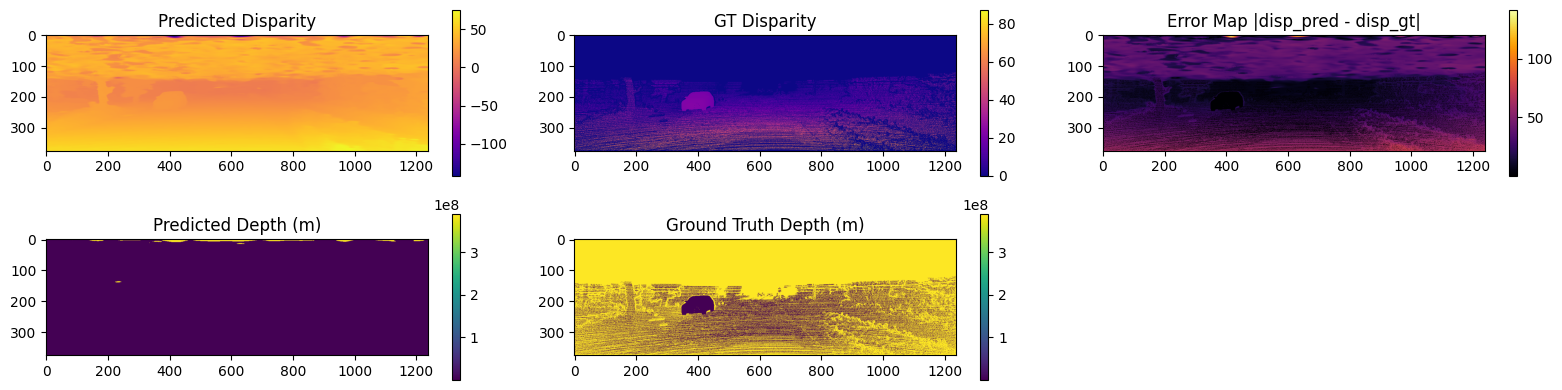

(array([[23.51165 , 25.04242 , 26.391434, ..., 28.668076, 36.800938,
         44.525955],
        [29.774782, 31.349491, 31.832493, ..., 32.984177, 40.719196,
         47.75088 ],
        [32.352425, 32.681118, 31.308641, ..., 37.754204, 44.968243,
         49.64165 ],
        ...,
        [62.07619 , 61.8878  , 61.725605, ..., 71.89393 , 71.845436,
         71.79604 ],
        [61.611286, 61.470585, 61.372707, ..., 72.49398 , 72.58095 ,
         72.60903 ],
        [61.09157 , 60.930527, 60.805218, ..., 72.74474 , 73.04088 ,
         73.18528 ]], dtype=float32),
 {'MAE': np.float32(0.45887217),
  'RMSE': np.float32(0.7232085),
  'Bad1%': np.float64(9.225665004559477),
  'Bad3%': np.float64(0.45109718476552646)})

In [5]:
model = FNO2d(24, 12, 32)

run_full_evaluation(
    model=model,
    checkpoint_path="Fast-ACVNet-main/fno_stereo_extra1000.pth",
    left_path="Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_2/000157_10.png",
    right_path="Fast-ACVNet-main/data/KITTI/KITTI_2015/training/image_3/000157_10.png",
    gt_disp_path="Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0/000157_10.png"
)


Loading checkpoint...

📌 Evaluation Metrics


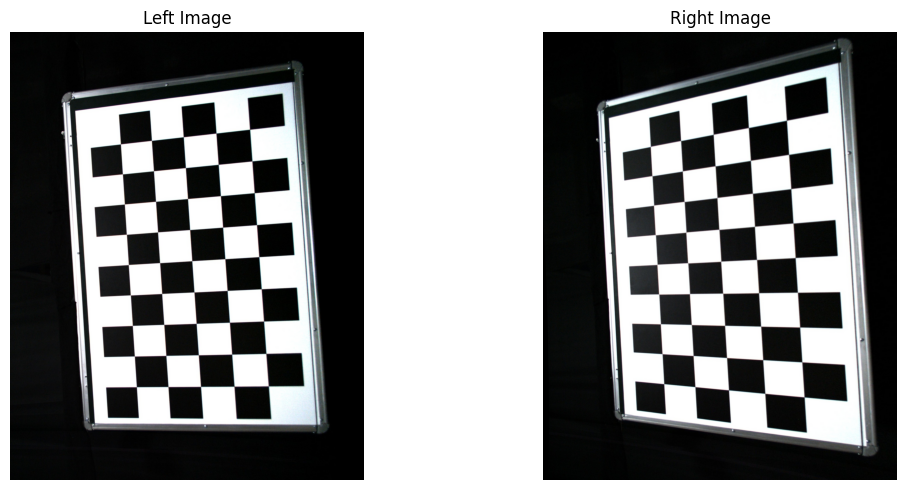

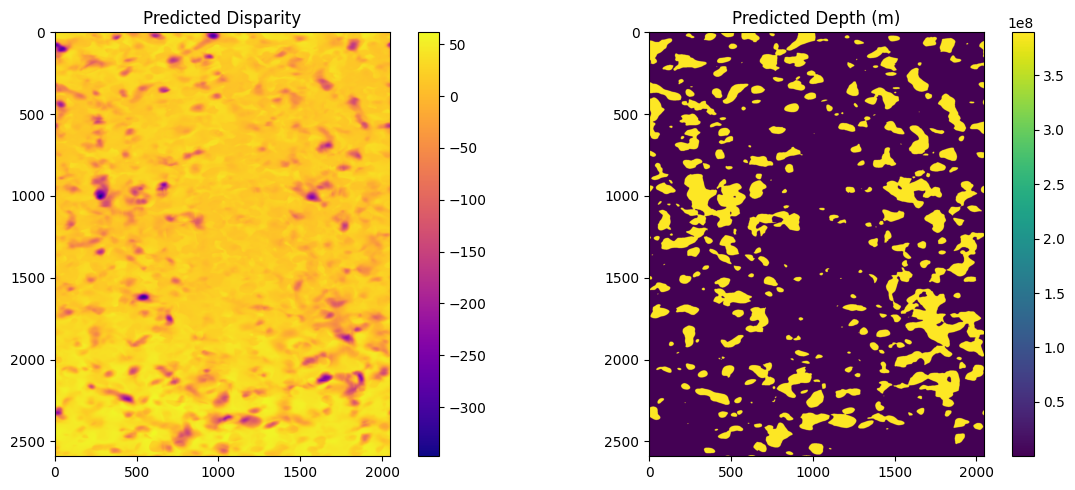

array([[ 9.868672 , 10.620517 , 11.381135 , ...,  8.532801 ,  8.815004 ,
         9.168963 ],
       [10.0960455, 10.866729 , 11.668109 , ...,  8.301832 ,  8.6406   ,
         9.045761 ],
       [10.433013 , 11.229768 , 12.084512 , ...,  8.177764 ,  8.574123 ,
         9.030789 ],
       ...,
       [23.725033 , 24.24624  , 24.77131  , ..., 26.528997 , 26.785526 ,
        27.076645 ],
       [22.63607  , 23.217066 , 23.826736 , ..., 24.746391 , 25.02246  ,
        25.336868 ],
       [21.58689  , 22.228811 , 22.889837 , ..., 23.109295 , 23.402956 ,
        23.743378 ]], dtype=float32)

In [ ]:
from matplotlib.image import BboxImage
# Plotting Block

import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# ---------------------------
# Metric Function
# ---------------------------
def evaluate_vs_gt(disp_pred, disp_gt):
    mask = disp_gt > 0  # KITTI valid region

    diff = np.abs(disp_pred - disp_gt)

    mae  = np.mean(diff[mask])
    rmse = np.sqrt(np.mean((diff[mask])**2))
    bad1 = np.mean(diff[mask] > 1.0) * 100
    bad3 = np.mean(diff[mask] > 3.0) * 100

    return {
        "MAE": mae,
        "RMSE": rmse,
        "Bad1%": bad1,
        "Bad3%": bad3
    }

# ---------------------------
# Load RGB image (C,H,W)
# ---------------------------
def load_rgb(path):
    img = np.asarray(Image.open(path).convert("RGB"), dtype=np.float32) / 255.0
    img = torch.from_numpy(img).permute(2,0,1).float()  # (3,H,W)
    return img

# ---------------------------
# Load KITTI disparity GT
# ---------------------------
def load_disp_kitti(path):
    disp_raw = np.asarray(Image.open(path), dtype=np.uint16)
    disp = disp_raw.astype(np.float32) / 256.0
    return disp

# ---------------------------
# Full Evaluation Function
# ---------------------------
def run_full_evaluation(
    model,
    checkpoint_path,
    left_path,
    right_path,
    gt_disp_path,
    focal_length=721.5,
    baseline=0.54
):
    # ---------------------------
    # Load model weights
    # ---------------------------
    print("Loading checkpoint...")
    state = torch.load(checkpoint_path, map_location="cpu")

    if isinstance(state, dict) and "state_dict" in state:
        model.load_state_dict(state["state_dict"])
    else:
        model.load_state_dict(state)

    model.eval().cpu()

    # ---------------------------
    # Load images
    # ---------------------------
    left  = load_rgb(left_path)
    right = load_rgb(right_path)

    inp = torch.cat([left, right], dim=0).unsqueeze(0)  # (1,6,H,W)
    inp_for_model = inp.permute(0, 2, 3, 1)             # (1,H,W,6)

    # ---------------------------
    # Run inference
    # ---------------------------
    with torch.no_grad():
        pred = model(inp_for_model)

    pred_disp = pred.squeeze().cpu().numpy()

    # ---------------------------
    # Load GT
    # ---------------------------
    # gt_disp = load_disp_kitti(gt_disp_path)

    # ---------------------------
    # Compute metrics
    # ---------------------------
    #metrics = evaluate_vs_gt(pred_disp, gt_disp)
    print("\n📌 Evaluation Metrics")
    #for k,v in metrics.items():
      #  print(f"{k}: {v:.4f}")

    # ---------------------------
    # Depth maps
    # ---------------------------
    depth_pred = (focal_length * baseline) / np.maximum(pred_disp, 1e-6)
    #depth_gt   = (focal_length * baseline) / np.maximum(gt_disp, 1e-6)

    # ---------------------------
    # 💡 Plot 1: LEFT + RIGHT IMAGE
    # ---------------------------
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.title("Left Image")
    plt.imshow(left.permute(1,2,0).cpu().numpy())
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title("Right Image")
    plt.imshow(right.permute(1,2,0).cpu().numpy())
    plt.axis('off')

    plt.tight_layout()
    plt.savefig("FNO1fig.png")
    plt.show()

    # ---------------------------
    # 💡 Plot 2: GT Disparity + Error Map
    # ---------------------------
    #error_map = np.abs(pred_disp - gt_disp)

    # plt.figure(figsize=(12,5))

    # plt.subplot(1,2,1)
    # plt.title("Ground Truth Disparity")
    # plt.imshow(gt_disp, cmap='plasma')
    # plt.colorbar()

    # plt.subplot(1,2,2)
    # plt.title("Disparity Error |pred - gt|")
    # plt.imshow(error_map, cmap='inferno')
    # plt.colorbar()

    # plt.tight_layout()
    # plt.savefig("disp_gt.png", dpi=330, bbox_inches='tight',pad_inches=0.05)
    # plt.show()

    # ---------------------------
    # 💡 Plot 3: Predicted Disparity + Predicted Depth
    # ---------------------------
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.title("Predicted Disparity")
    plt.imshow(pred_disp, cmap='plasma')
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.title("Predicted Depth (m)")
    plt.imshow(depth_pred, cmap='viridis')
    plt.colorbar()

    plt.tight_layout()
    plt.savefig("disp_depth.png", dpi=330, bbox_inches='tight',pad_inches=0.05)
    plt.show()

    return pred_disp#, metrics

model = FNO2d(24, 12, 32)

run_full_evaluation(
    model=model,
    checkpoint_path="Fast-ACVNet-main/fno_stereo_extra1000.pth",
    left_path="Fast-ACVNet-main/data/resample/1_left.jpg",
    right_path="Fast-ACVNet-main/data/resample/1_right.jpg",
    gt_disp_path="Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0/000157_10.png"
)

Loading checkpoint...

📌 Evaluation Metrics


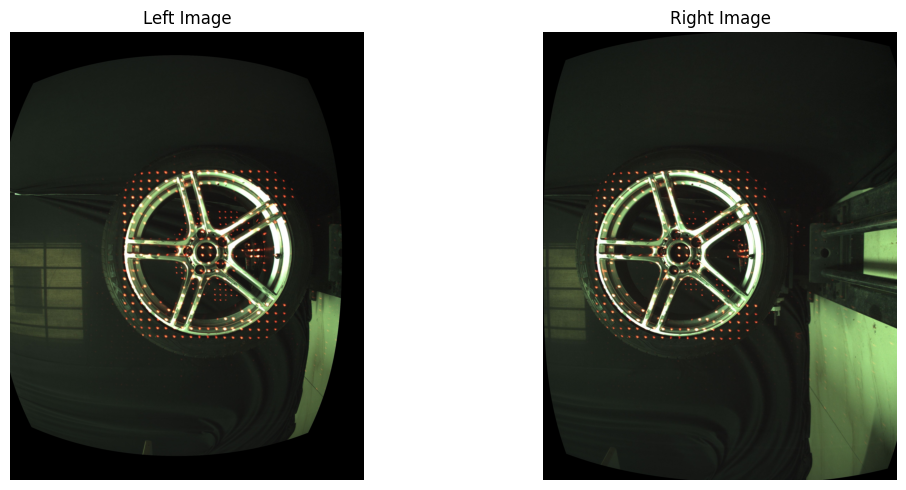

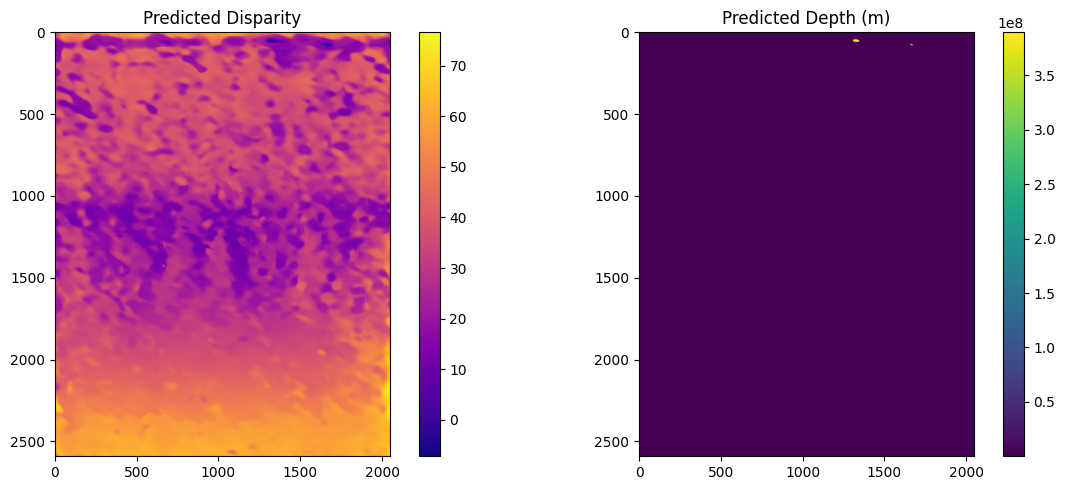

array([[39.555935, 39.50729 , 39.463795, ..., 41.82768 , 41.721375,
        41.64935 ],
       [39.454132, 39.399124, 39.34831 , ..., 41.42406 , 41.30691 ,
        41.22499 ],
       [39.35663 , 39.296623, 39.239628, ..., 41.07124 , 40.94796 ,
        40.860615],
       ...,
       [42.93518 , 43.236702, 43.586544, ..., 67.79522 , 68.18276 ,
        68.577446],
       [42.5964  , 42.845306, 43.16447 , ..., 67.60109 , 67.98582 ,
        68.38262 ],
       [42.348175, 42.53137 , 42.796474, ..., 67.39709 , 67.775665,
        68.17143 ]], dtype=float32)

In [ ]:
run_full_evaluation(
    model=model,
    checkpoint_path="Fast-ACVNet-main/fno_stereo_extra1000.pth",
    left_path="Fast-ACVNet-main/data/resample/ROT_TOP_0l_left.jpg",
    right_path="Fast-ACVNet-main/data/resample/ROT_BOT_0l_right.jpg",
    gt_disp_path="Fast-ACVNet-main/data/KITTI/KITTI_2015/training/disp_occ_0/000157_10.png"
)